In [23]:
import csv

import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import load_model

RANDOM_SEED = 42

# Specify each path

In [24]:
dataset = 'model/keypoint_classifier/keypoint.csv'
model_save_path = 'model/keypoint_classifier/keypoint_classifier.keras'
tflite_save_path = 'model/keypoint_classifier/keypoint_classifier.tflite'

# Step 1: Load the model from the .hdf5 file
model = load_model("model/keypoint_classifier/keypoint_classifier.keras")

# Step 2: Save the model in the .keras format
model.save("model/keypoint_classifier/keypoint_classifier.keras")

# Set number of classes

In [25]:
NUM_CLASSES = 7

# Dataset reading

In [26]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (21 * 2) + 1)))

In [27]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model building

In [29]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Input((21 * 2,)),  # Input layer for 42 coordinates
    tf.keras.layers.BatchNormalization(),  # Normalize input for better performance
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Wider layer
    tf.keras.layers.LeakyReLU(alpha=0.1),  # Leaky ReLU activation with a small slope
    tf.keras.layers.Dropout(0.3),  # Moderate dropout for regularization
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(0.001)),  # Another hidden layer
    tf.keras.layers.LeakyReLU(alpha=0.1),  # Leaky ReLU activation
    tf.keras.layers.Dropout(0.2),  # Lower dropout for a smaller layer
    tf.keras.layers.BatchNormalization(),

    tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')  # Output layer for classification
])

c:\Users\dteh6\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


In [30]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_normalization_3           │ (None, 42)             │           168 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │         5,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_2 (LeakyReLU)       │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ leaky_re_lu_3 (LeakyReLU)       │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 7)              │           455 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 15,151 (59.18 KB)

 Trainable params: 14,683 (57.36 KB)

 Non-trainable params: 468 (1.83 KB)

In [31]:
# Model checkpoint callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Callback for early stopping
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [32]:
# Model compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model training

In [33]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
 1/37 ━━━━━━━━━━━━━━━━━━━━ 58s 2s/step - accuracy: 0.1562 - loss: 2.5829
Epoch 1: saving model to model/keypoint_classifier/keypoint_classifier.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 2s 6ms/step - accuracy: 0.5070 - loss: 1.5951 - val_accuracy: 0.4210 - val_loss: 1.6988
Epoch 2/1000
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.8516 - loss: 0.6315
Epoch 2: saving model to model/keypoint_classifier/keypoint_classifier.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9025 - loss: 0.4838 - val_accuracy: 0.7827 - val_loss: 1.3464
Epoch 3/1000
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.9141 - loss: 0.4004
Epoch 3: saving model to model/keypoint_classifier/keypoint_classifier.keras
37/37 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.9439 - loss: 0.3456 - val_accuracy: 0.8788 - val_loss: 1.0237
Epoch 4/1000
 1/37 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.9766 - loss: 0.2893
Epoch 4: saving model to model/keypoint_classifier/keypoint_classifier.keras


In [34]:
# Model evaluation
val_loss, val_acc = model.evaluate(X_test, y_test, batch_size=128)

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 878us/step - accuracy: 1.0000 - loss: 0.0150


In [35]:
# Loading the saved model
model = tf.keras.models.load_model(model_save_path)

In [36]:
# Inference test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[7.4715016e-09 1.7353679e-08 1.2322671e-07 3.0779163e-10 4.6154146e-11
 9.9999976e-01 1.4890085e-07]
5


# Confusion matrix

49/49 ━━━━━━━━━━━━━━━━━━━━ 0s 722us/step


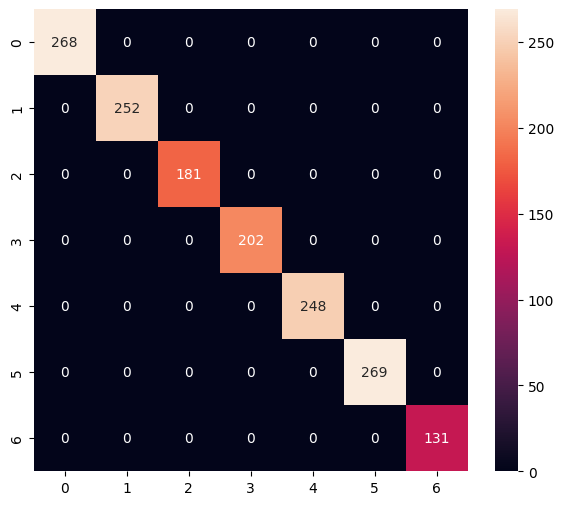

Classification Report
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       268
           1       1.00      1.00      1.00       252
           2       1.00      1.00      1.00       181
           3       1.00      1.00      1.00       202
           4       1.00      1.00      1.00       248
           5       1.00      1.00      1.00       269
           6       1.00      1.00      1.00       131

    accuracy                           1.00      1551
   macro avg       1.00      1.00      1.00      1551
weighted avg       1.00      1.00      1.00      1551



In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to model for Tensorflow-Lite

In [38]:
# Save as a model dedicated to inference
model.save(model_save_path, include_optimizer=False)

In [39]:
# Transform model (quantization)

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: C:\Users\dteh6\AppData\Local\Temp\tmpj7bdklda\assets


INFO:tensorflow:Assets written to: C:\Users\dteh6\AppData\Local\Temp\tmpj7bdklda\assets


Saved artifact at 'C:\Users\dteh6\AppData\Local\Temp\tmpj7bdklda'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 42), dtype=tf.float32, name='input_layer_1')
Output Type:
  TensorSpec(shape=(None, 7), dtype=tf.float32, name=None)
Captures:
  2644493435344: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420862288: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644493436688: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644493439376: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420854800: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420854416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420863440: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420860176: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420863632: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420859024: TensorSpec(shape=(), dtype=tf.resource, name=None)
  2644420861904

21384

# Inference test

In [40]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

In [41]:
# Get I / O tensor
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

In [42]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [43]:
%%time
# Inference implementation
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: total: 0 ns
Wall time: 1.01 ms


In [44]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[9.0629593e-09 1.9210896e-08 1.2109558e-07 3.7377562e-10 4.8868201e-11
 9.9999964e-01 1.6939600e-07]
5
